In [ ]:
!shred -u setup_colab.py
!shred -u setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/setup_colab_general.py" -O setup_colab_general.py
!wget -q "https://github.com/jpcano1/python_utils/raw/main/ISIS_4825/setup_colab.py" -O setup_colab.py
import setup_colab as setup
setup.setup_extra_workshop()

shred: setup_colab.py: failed to open for writing: No such file or directory
shred: setup_colab_general.py: failed to open for writing: No such file or directory



General Functions Enabled Successfully



Util Functions Downloaded Successfully




Extracting Zip File...


## **Importar las Librerías Necesarias para el Taller**

In [76]:
from utils import general as gen
from utils import extra_utils as extra

from tensorflow import keras
from tensorflow.keras.utils import Sequence

from torch.utils.data import Dataset

from skimage import filters, morphology
import cv2

from tqdm.auto import tqdm

import nibabel as nib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use("seaborn-deep")
import seaborn as sns

In [4]:
data_dir = gen.create_and_verify("data", "media", "nas", "01_Datasets", 
                                 "CT", "LITS", "Training Batch 1")
data_list = gen.read_listdir(data_dir)

## **Preparación de los Datos con Generadores**

In [5]:
class ClassicDataGenerator:
    def __init__(self, data_dirs, as_array=False, transform=None, 
                 *args, **kwargs):
        self.volume_dirs = [p for p in data_list if "segmentation" not in p]
        self.label_dirs =  [p for p in data_list if "segmentation" in p]
        self.as_array = as_array
        self.transform = transform

    def __len__(self):
        return len(self.volume_dirs)

    def __getitem__(self, idx):
        vol = nib.load(self.volume_dirs[idx])
        lab = nib.load(self.label_dirs[idx])

        if self.as_array:
            return vol.get_fdata(), lab.get_fdata()
        return vol, lab

    def __iter__(self):
        self.idx = 0
        return self

    def __next__(self):
        if self.idx < self.__len__():
            vol = nib.load(self.volume_dirs[self.idx])
            lab = nib.load(self.label_dirs[self.idx])
            self.idx += 1

            if self.as_array:
                return vol.get_fdata(), lab.get_fdata()
            return vol, lab
        else:
            raise StopIteration

In [6]:
lits_dataset = ClassicDataGenerator(data_list)

In [ ]:
for X, y in lits_dataset:
    print(f"Volume shape: {X.shape}")
    print(f"Label shape: {y.shape}")

In [8]:
class KerasDataGenerator(Sequence):
    def __init__(self, data_dirs, as_array=False):
        super(KerasDataGenerator, self).__init__()
        self.volume_dirs = [p for p in data_list if "segmentation" not in p]
        self.label_dirs = [p for p in data_list if "segmentation" in p]
        self.as_array = as_array

    def __len__(self):
        return len(self.volume_dirs)

    def __getitem__(self, idx):
        vol = nib.load(self.volume_dirs[idx])
        lab = nib.load(self.label_dirs[idx])
        if self.as_array:
            return vol.get_fdata(), lab.get_fdata()
        return vol, lab

In [9]:
lits_dataset = KerasDataGenerator(data_list)

In [ ]:
for X, y in lits_dataset:
    print(f"Volume shape: {X.shape}")
    print(f"Label shape: {y.shape}")

In [10]:
class TorchDataGenerator(Dataset):
    def __init__(self, data_dir, as_array=False, transform=None):
        super(TorchDataGenerator, self).__init__()
        self.volume_dirs = [p for p in data_list if "segmentation" not in p]
        self.label_dirs = [p for p in data_list if "segmentation" in p]
        
        self.as_array = as_array
        self.transform = transform

    def __len__(self):
        return len(self.volume_dirs)

    def __getitem__(self, idx):
        vol = nib.load(self.volume_dirs[idx])
        lab = nib.load(self.label_dirs[idx])
        if self.as_array:
            return vol.get_fdata(), lab.get_fdata()
        return vol, lab

In [11]:
lits_dataset = TorchDataGenerator(data_list)

In [ ]:
for X, y in lits_dataset:
    print(f"Volume shape: {X.shape}")
    print(f"Label shape: {y.shape}")

## **Visualización y Análisis Exploratorio**

In [12]:
lits_dataset = ClassicDataGenerator(data_list, as_array=True)

In [13]:
np.random.seed(1234)
random_sample = np.random.randint(0, len(lits_dataset))

In [14]:
vol, lab = lits_dataset[random_sample]

In [15]:
vol.shape, lab.shape

((512, 512, 247), (512, 512, 247))

In [16]:
vol_slice, lab_slice = extra.get_vol_slice(vol, lab, 130)
vol_slice.shape, lab_slice.shape

((512, 512), (512, 512))

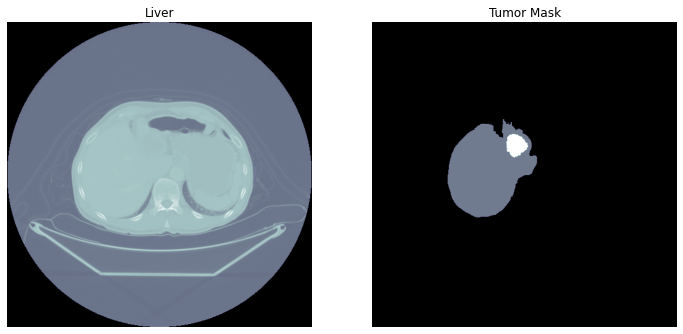

In [17]:
gen.visualize_subplot([vol_slice, lab_slice], ["Liver", "Tumor Mask"], (1, 2), 
                      cmap="bone", figsize=(12, 6))

In [18]:
labeled_image = extra.get_labeled_image(vol_slice, lab_slice, 3)

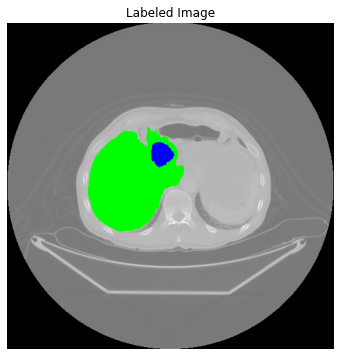

In [20]:
plt.figure(figsize=(6, 6))
gen.imshow(labeled_image, title="Labeled Image")

In [71]:
def pipeline(img):
    selem = morphology.square(10)
    img = filters.median(img)
    img = filters.rank.mean_bilateral(img, selem)
    return img

In [72]:
preprocessed = pipeline(vol_slice)

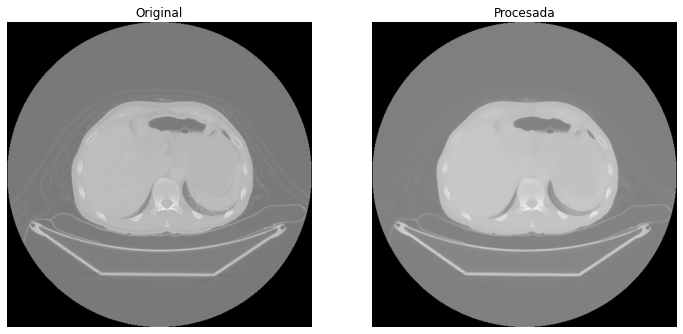

In [75]:
gen.visualize_subplot([vol_slice, preprocessed], 
                      ["Original", "Procesada"], (1, 2), (12, 6))

In [95]:
extra.create_data(lits_dataset, sanity_check=True)

Volumen Cargado


In [96]:
X = np.load("train_data/data/X_0.npy")
y = np.load("train_data/labels/y_0.npy")

In [97]:
X.shape

(224, 224)

In [98]:
y.shape

(224, 224, 2)

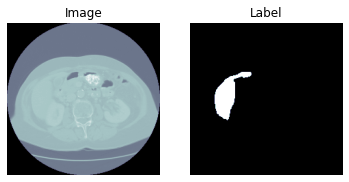

In [101]:
gen.visualize_subplot([X, y[..., 0]], ["Image", "Label"], (1, 2), 
                      cmap="bone")

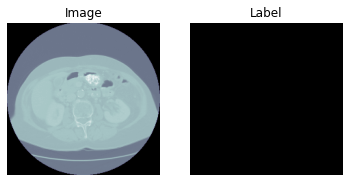

In [102]:
gen.visualize_subplot([X, y[..., 1]], ["Image", "Label"], (1, 2), 
                      cmap="bone")